In [1]:
# import package needed
%matplotlib inline
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["SDL_VIDEODRIVER"] = "dummy"  # this line make pop-out window not appear
import numpy as np
from ple.games.flappybird import FlappyBird
from ple import PLE
game = FlappyBird()
env = PLE(game, fps=30, display_screen=False)  # environment interface to game
env.reset_game()

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html
couldn't import doomish
Couldn't import doom


In [2]:
import math
import copy
from collections import defaultdict
import tensorflow as tf
MIN_EXPLORING_RATE = 10e-4

class Agent:   
    def __init__(self, name, num_action, t=0, discount_factor=0.99):
        self.exploring_rate = 0.5
        self.discount_factor = discount_factor
        self.num_action = num_action
        self.name = name
        with tf.variable_scope(name):
            self.build_model()

    def build_model(self):
        # input: current screen, selected action and reward
        self.input_screen = tf.placeholder(tf.float32, shape=[None,len(game.getGameState())])
        self.action = tf.placeholder(tf.int32, [None])
        self.reward = tf.placeholder(tf.float32, [None])
        self.is_training = tf.placeholder(tf.bool, shape=[])

        def net(screen, reuse=False):
            with tf.variable_scope("layers",reuse=reuse,
                  initializer=tf.truncated_normal_initializer(stddev=1e-2)):
                #flat =
                dense = tf.layers.dense(inputs=screen, units=1024, activation=tf.nn.relu)
                Q = tf.layers.dense(inputs=dense, units=self.num_action, activation=None)
                return Q

         # optimize
        self.output = net(self.input_screen
                     )  # Q(s,a,theta) for all a, shape (batch_size, num_action)
        index = tf.stack([tf.range(tf.shape(self.action)[0]), self.action], axis=1)
        self.esti_Q = tf.gather_nd(self.output,index)  # Q(s,a,theta) for selected action, shape (batch_size, 1)

        self.max_Q = tf.reduce_max(self.output, axis=1)  # max(Q(s',a',theta')), shape (batch_size, 1)
        self.tar_Q = tf.placeholder(tf.float32, [None])

        # loss = E[r+max(Q(s',a',theta'))-Q(s,a,theta)]
        self.loss = tf.reduce_mean(tf.square(self.reward + self.discount_factor * self.tar_Q -self.esti_Q))
        optimizer = tf.train.AdamOptimizer(learning_rate=1e-5)
        self.g_gvs = optimizer.compute_gradients(self.loss,
            var_list=[v for v in tf.global_variables() if self.name in v.name])
        self.train_op = optimizer.apply_gradients(self.g_gvs)
        self.pred = tf.argmax(self.output, axis=1)  # select action with highest action-value, only used in inference

    def select_action(self, input_screen, sess):
        # epsilon-greedy
        if np.random.rand() < self.exploring_rate:
            action = np.random.choice(num_action)  # Select a random action
        else:
            state_idx = input_screen
            feed_dict = {
                self.input_screen: np.array(state_idx).reshape([-1,8]),
                self.is_training: False,
                }
            action = sess.run(self.pred,
                  feed_dict=feed_dict)[0]  # Select the action with the highest q
        return action

    def update_policy(self, input_screens, actions, rewards, input_screens_plum,terminal, target_netwrok):
        state_idx = input_screens
        state_prime_idx = input_screens_plum
    
        # use max_Q estimate from target one to update online one
        feed_dict = {
            target_netwrok.input_screen:
             np.array(state_prime_idx).reshape([-1,8]),
             target_netwrok.is_training:
             True,
             }
        max_Q = sess.run(target_netwrok.max_Q, feed_dict=feed_dict)
        max_Q *= ~np.array(terminal)
        feed_dict = {
            self.input_screen: np.array(state_idx).reshape([-1,8]),
            self.tar_Q: max_Q,
            self.action: actions,
            self.reward: rewards,
            self.is_training: True,
        }
        loss, _ = sess.run([self.loss, self.train_op], feed_dict=feed_dict)
        return loss

    def update_parameters(self, episode):
        self.exploring_rate = max(MIN_EXPLORING_RATE,min(0.5, 0.99**((episode) / 210)))

    def shutdown_explore(self):
        # make action selection greedy
        self.exploring_rate = 0

In [3]:
def get_update_ops():
    # return operations assign weight to target network
    src_vars = [v for v in tf.global_variables() if 'online' in v.name]
    tar_vars = [v for v in tf.global_variables() if 'target' in v.name]
    update_ops = []
    for src_var, tar_var in zip(src_vars, tar_vars):
        update_ops.append(tar_var.assign(src_var))
    return update_ops


def update_target(update_ops, sess):
    sess.run(update_ops)
# init agent
tf.reset_default_graph()
num_action = len(env.getActionSet())

# agent for frequently updating
online_agent = Agent('online', num_action)

# agent for slow updating
target_agent = Agent('target', num_action)
update_ops = get_update_ops()

In [4]:
class Replay_buffer():
    def __init__(self, buffer_size=50000):
        self.experiences = []
        self.buffer_size = buffer_size
  
    def add(self, experience):
        if len(self.experiences) >= self.buffer_size:
            self.experiences.pop(0)
        self.experiences.append(experience)
  
    def sample(self, size):
        """
        sameple experience from buffer
        """
        if size > len(self.experiences):
            experiences_idx = np.random.choice(len(self.experiences), size=size)
        else:
            experiences_idx = np.random.choice(len(self.experiences), size=size, replace=False)
        # from all sampled experiences, extract a tuple of (s,a,r,s')
        screens = []
        actions = []
        rewards = []
        screens_plum = []
        terminal = []
        for i in range(size):
            screens.append(self.experiences[experiences_idx[i]][0])
            actions.append(self.experiences[experiences_idx[i]][1])
            rewards.append(self.experiences[experiences_idx[i]][2])
            screens_plum.append(self.experiences[experiences_idx[i]][3])
            terminal.append(self.experiences[experiences_idx[i]][4])
        return screens, actions, rewards, screens_plum, terminal
# init buffer
buffer = Replay_buffer()

In [5]:
def make_anim(images, fps=60, true_image=False):
    duration = len(images) / fps
    import moviepy.editor as mpy
  
    def make_frame(t):
        try:
            x = images[int(len(images) / duration * t)]
        except:
            x = images[-1]
    
        if true_image:
            return x.astype(np.uint8)
        else:
            return ((x + 1) / 2 * 255).astype(np.uint8)
  
    clip = mpy.VideoClip(make_frame, duration=duration)
    clip.fps = fps
    return clip

In [6]:
# init all
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

In [7]:
from IPython.display import Image, display
reward_per_epoch = []
lifetime_per_epoch = []

update_every_t_step = 10
print_every_episode = 100
save_video_every_episode = 2000
NUM_EPISODE = 100000
NUM_EXPLORE = 20

# we can redefine origin reward function
reward_values = {
    "positive": 1,  # reward pass a pipe
    "tick": 0.1,  # reward per timestamp
    "loss": -1,  # reward of gameover
}
for episode in range(0, NUM_EPISODE + 1):
  # Reset the environment
  game = FlappyBird()
  # for demo purpose, the following code is trained in the same scene,
  env = PLE(
      game,
      fps=30,
      display_screen=False,
      reward_values=reward_values,
      rng=np.random.RandomState(1))
  env.reset_game()
  env.act(0)  # dummy input to make sure input screen is correct

  # record frame
  if episode % save_video_every_episode == 0:
    frames = [env.getScreenRGB()]

  # for every 500 episodes, shutdown exploration to see performance of greedy action
  if episode % print_every_episode == 0:
    online_agent.shutdown_explore()

  state = np.array(tuple(game.getGameState().values()))
  # experience for this episode, store all (s,a,r,s') tuple
  experience = []

  # cumulate reward for this episode
  cum_reward = 0

  t = 0
  while not env.game_over():

    # feed four previous screen, select an action
    action = online_agent.select_action(state, sess)

    # execute the action and get reward
    reward = env.act(env.getActionSet()[action])

    # record frame
    if episode % save_video_every_episode == 0:
      frames.append(env.getScreenRGB())

    # cumulate reward
    cum_reward += reward
    
    state_prime = np.array(tuple(game.getGameState().values())) # get next state

    # append experience for this episode
    buffer.add((state, action, reward, state_prime,
                env.game_over()))
    
    state = state_prime 
    t += 1

    # update agent
  if episode > NUM_EXPLORE:
    train_screens, train_actions, train_rewards, train_screens_plum, terminal = buffer.sample(
        32)
    loss = online_agent.update_policy(train_screens, train_actions,
                                      train_rewards, train_screens_plum,
                                      terminal, target_agent)
  if t % update_every_t_step == 0 and episode > NUM_EXPLORE:
    update_target(update_ops, sess)

  # update explore rating and learning rate
  online_agent.update_parameters(episode)
  target_agent.update_parameters(episode)

  if episode % print_every_episode == 0 and episode > NUM_EXPLORE:
    print(
        "[{}] time live:{}, cumulated reward: {}, exploring rate: {}, loss: {}".
        format(episode, t, cum_reward, target_agent.exploring_rate, loss))
    reward_per_epoch .append(cum_reward)
    lifetime_per_epoch.append(t)
    
    
  if episode % save_video_every_episode == 0:  # for every 100 episode, record an animation
    clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
    clip.write_videofile("movie/DQN-{}.webm".format(episode), fps=60)

[MoviePy] >>>> Building video movie/DQN-0.webm
[MoviePy] Writing video movie/DQN-0.webm


 97%|█████████▋| 33/34 [00:00<00:00, 82.43it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-0.webm 



[100] time live:32, cumulated reward: 2.200000000000002, exploring rate: 0.5, loss: 0.04360179603099823
[200] time live:32, cumulated reward: 2.200000000000002, exploring rate: 0.5, loss: 0.13520555198192596
[300] time live:32, cumulated reward: 2.200000000000002, exploring rate: 0.5, loss: 0.16083134710788727
[400] time live:32, cumulated reward: 2.200000000000002, exploring rate: 0.5, loss: 0.003812868846580386
[500] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.0023155566304922104
[600] time live:32, cumulated reward: 2.200000000000002, exploring rate: 0.5, loss: 0.0017342139035463333
[700] time live:20, cumulated reward: 1.0000000000000007, exploring rate: 0.5, loss: 0.03682144358754158
[800] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.0037934998981654644
[900] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.004085620865225792
[1000] time live:32, cumulated reward: 2.20000000000000

 95%|█████████▌| 21/22 [00:00<00:00, 74.07it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-2000.webm 



[2100] time live:20, cumulated reward: 1.0000000000000007, exploring rate: 0.5, loss: 0.002620043931528926
[2200] time live:20, cumulated reward: 1.0000000000000007, exploring rate: 0.5, loss: 0.004270843230187893
[2300] time live:20, cumulated reward: 1.0000000000000007, exploring rate: 0.5, loss: 0.16454006731510162
[2400] time live:20, cumulated reward: 1.0000000000000007, exploring rate: 0.5, loss: 0.1664074957370758
[2500] time live:20, cumulated reward: 1.0000000000000007, exploring rate: 0.5, loss: 0.0032590569462627172
[2600] time live:20, cumulated reward: 1.0000000000000007, exploring rate: 0.5, loss: 0.0058976090513169765
[2700] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.03685203194618225
[2800] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.1314176321029663
[2900] time live:20, cumulated reward: 1.0000000000000007, exploring rate: 0.5, loss: 0.08522376418113708
[3000] time live:20, cumulated reward: 1.000

100%|██████████| 63/63 [00:00<00:00, 80.86it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-4000.webm 



[4100] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.0012163229985162616
[4200] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.0024315877817571163
[4300] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.02455647476017475
[4400] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.0015815335791558027
[4500] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.03664436191320419
[4600] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.056764740496873856
[4700] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.0005950400372967124
[4800] time live:97, cumulated reward: 9.699999999999982, exploring rate: 0.5, loss: 0.01022431068122387
[4900] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.057796310633420944
[5000] time live:61, cumulated reward: 5.0999

100%|██████████| 63/63 [00:00<00:00, 77.08it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-6000.webm 



[6100] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.03723520785570145
[6200] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.0011098231188952923
[6300] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.004082823172211647
[6400] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.013150103390216827
[6500] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.07672396302223206
[6600] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.0030068669002503157
[6700] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.0012067878851667047
[6800] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.05858718603849411
[6900] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.005028668791055679
[7000] time live:61, cumulated reward: 5.09999

 99%|█████████▊| 66/67 [00:00<00:00, 78.01it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-8000.webm 



[8100] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.004785512108355761
[8200] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.11428168416023254
[8300] time live:66, cumulated reward: 6.5999999999999925, exploring rate: 0.5, loss: 0.04244636371731758
[8400] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.06501538306474686
[8500] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.005675814114511013
[8600] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.14945411682128906
[8700] time live:62, cumulated reward: 5.199999999999994, exploring rate: 0.5, loss: 0.11089669167995453
[8800] time live:67, cumulated reward: 6.699999999999992, exploring rate: 0.5, loss: 0.034848105162382126
[8900] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.00513251731172204
[9000] time live:65, cumulated reward: 6.4999999999

 99%|█████████▊| 74/75 [00:00<00:00, 91.72it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-10000.webm 



[10100] time live:75, cumulated reward: 7.499999999999989, exploring rate: 0.5, loss: 0.05621596425771713
[10200] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.17544429004192352
[10300] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.007709248922765255
[10400] time live:62, cumulated reward: 5.199999999999994, exploring rate: 0.5, loss: 0.008799275383353233
[10500] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.13450606167316437
[10600] time live:75, cumulated reward: 7.499999999999989, exploring rate: 0.5, loss: 0.013027328997850418
[10700] time live:76, cumulated reward: 7.599999999999989, exploring rate: 0.5, loss: 0.005958654917776585
[10800] time live:68, cumulated reward: 6.799999999999992, exploring rate: 0.5, loss: 0.46677297353744507
[10900] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.5, loss: 0.03988059610128403
[11000] time live:61, cumulated reward: 5.

 99%|█████████▊| 78/79 [00:00<00:00, 84.33it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-12000.webm 



[12100] time live:97, cumulated reward: 9.699999999999982, exploring rate: 0.5, loss: 0.009098335169255733
[12200] time live:70, cumulated reward: 6.999999999999991, exploring rate: 0.5, loss: 0.012811106629669666
[12300] time live:68, cumulated reward: 6.799999999999992, exploring rate: 0.5, loss: 0.01695723831653595
[12400] time live:70, cumulated reward: 6.999999999999991, exploring rate: 0.5, loss: 0.01891590654850006
[12500] time live:70, cumulated reward: 6.999999999999991, exploring rate: 0.5, loss: 0.023622840642929077
[12600] time live:70, cumulated reward: 6.999999999999991, exploring rate: 0.5, loss: 0.012557893060147762
[12700] time live:97, cumulated reward: 9.699999999999982, exploring rate: 0.5, loss: 0.02296036295592785
[12800] time live:108, cumulated reward: 11.799999999999978, exploring rate: 0.5, loss: 0.2936972975730896
[12900] time live:67, cumulated reward: 6.699999999999992, exploring rate: 0.5, loss: 0.3986511528491974
[13000] time live:62, cumulated reward: 5.

 99%|█████████▊| 74/75 [00:00<00:00, 91.01it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-14000.webm 



[14100] time live:65, cumulated reward: 6.499999999999993, exploring rate: 0.5, loss: 0.19800326228141785
[14200] time live:63, cumulated reward: 5.299999999999994, exploring rate: 0.5, loss: 0.7234485149383545
[14300] time live:63, cumulated reward: 5.299999999999994, exploring rate: 0.5, loss: 0.2263314425945282
[14400] time live:62, cumulated reward: 5.199999999999994, exploring rate: 0.5, loss: 0.036366865038871765
[14500] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.49959787141752704, loss: 0.27008259296417236
[14600] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.4972125712724545, loss: 0.026099856942892075
[14700] time live:72, cumulated reward: 7.19999999999999, exploring rate: 0.49483865960020695, loss: 0.02503061108291149
[14800] time live:72, cumulated reward: 7.19999999999999, exploring rate: 0.49247608202720233, loss: 0.01402037963271141
[14900] time live:75, cumulated reward: 7.499999999999989, exploring rate: 0.49012478443946

 99%|█████████▊| 70/71 [00:00<00:00, 75.45it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-16000.webm 



[16100] time live:77, cumulated reward: 7.699999999999989, exploring rate: 0.4627697037407071, loss: 0.04371944069862366
[16200] time live:103, cumulated reward: 11.29999999999998, exploring rate: 0.4605602374786994, loss: 0.0187370665371418
[16300] time live:102, cumulated reward: 11.19999999999998, exploring rate: 0.4583613201811625, loss: 0.4633755385875702
[16400] time live:64, cumulated reward: 5.399999999999993, exploring rate: 0.4561729014826968, loss: 0.03122052177786827
[16500] time live:98, cumulated reward: 9.799999999999981, exploring rate: 0.4539949312583692, loss: 0.7434661388397217
[16600] time live:97, cumulated reward: 9.699999999999982, exploring rate: 0.45182735962256493, loss: 0.023664137348532677
[16700] time live:103, cumulated reward: 11.29999999999998, exploring rate: 0.44967013692784547, loss: 0.03998976945877075
[16800] time live:106, cumulated reward: 11.599999999999978, exploring rate: 0.4475232137638106, loss: 0.1994318664073944
[16900] time live:112, cumul

 99%|█████████▊| 67/68 [00:00<00:00, 92.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-18000.webm 

[18100] time live:73, cumulated reward: 7.29999999999999, exploring rate: 0.4205284126653858, loss: 0.02094946801662445
[18200] time live:73, cumulated reward: 7.29999999999999, exploring rate: 0.41852062492023034, loss: 0.26730650663375854
[18300] time live:98, cumulated reward: 9.799999999999981, exploring rate: 0.41652242323753386, loss: 0.08290247619152069
[18400] time live:112, cumulated reward: 12.199999999999976, exploring rate: 0.4145337618492147, loss: 0.075319305062294
[18500] time live:112, cumulated reward: 12.199999999999976, exploring rate: 0.41255459520570825, loss: 0.03464507311582565
[18600] time live:102, cumulated reward: 11.19999999999998, exploring rate: 0.41058487797492343, loss: 0.023501059040427208
[18700] time live:108, cumulated reward: 11.799999999999978, exploring rate: 0.4086245650412046, loss: 0.6376760005950928
[18800] time live:111, cumulated reward: 12.099999999999977, exploring rate: 0.

100%|██████████| 247/247 [00:03<00:00, 71.15it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-20000.webm 



[20100] time live:111, cumulated reward: 12.099999999999977, exploring rate: 0.3821428767470828, loss: 0.26478147506713867
[20200] time live:109, cumulated reward: 11.899999999999977, exploring rate: 0.38031835844648043, loss: 0.05146389454603195
[20300] time live:72, cumulated reward: 7.19999999999999, exploring rate: 0.37850255119933945, loss: 0.0453384704887867
[20400] time live:107, cumulated reward: 11.699999999999978, exploring rate: 0.37669541341525636, loss: 0.609878420829773
[20500] time live:75, cumulated reward: 7.499999999999989, exploring rate: 0.37489690370239837, loss: 0.03156194090843201
[20600] time live:104, cumulated reward: 11.399999999999979, exploring rate: 0.37310698086655575, loss: 0.0165327750146389
[20700] time live:112, cumulated reward: 12.199999999999976, exploring rate: 0.37132560391019803, loss: 0.6449292302131653
[20800] time live:111, cumulated reward: 12.099999999999977, exploring rate: 0.36955273203153477, loss: 0.03585182875394821
[20900] time live:1

 99%|█████████▉| 114/115 [00:01<00:00, 85.07it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-22000.webm 



[22100] time live:108, cumulated reward: 11.799999999999978, exploring rate: 0.3472611453836167, loss: 0.03789931535720825
[22200] time live:111, cumulated reward: 12.099999999999977, exploring rate: 0.34560316782236056, loss: 0.28435438871383667
[22300] time live:106, cumulated reward: 11.599999999999978, exploring rate: 0.34395310617577024, loss: 0.15294495224952698
[22400] time live:112, cumulated reward: 12.199999999999976, exploring rate: 0.34231092264978485, loss: 0.035214073956012726
[22500] time live:109, cumulated reward: 11.899999999999977, exploring rate: 0.34067657963078896, loss: 0.048762932419776917
[22600] time live:112, cumulated reward: 12.199999999999976, exploring rate: 0.33905003968475095, loss: 0.02674313262104988
[22700] time live:174, cumulated reward: 19.40000000000002, exploring rate: 0.337431265556366, loss: 0.014586996287107468
[22800] time live:133, cumulated reward: 14.299999999999969, exploring rate: 0.3358202201682023, loss: 0.299942284822464
[22900] time

 99%|█████████▉| 111/112 [00:01<00:00, 72.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-24000.webm 

[24100] time live:112, cumulated reward: 12.199999999999976, exploring rate: 0.31556339377471315, loss: 0.1832979917526245
[24200] time live:109, cumulated reward: 11.899999999999977, exploring rate: 0.31405675523196935, loss: 0.06691639125347137
[24300] time live:108, cumulated reward: 11.799999999999978, exploring rate: 0.31255731004480247, loss: 0.03432706743478775
[24400] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.3110650238689667, loss: 0.7005918025970459
[24500] time live:111, cumulated reward: 12.099999999999977, exploring rate: 0.30957986252419073, loss: 0.054060257971286774
[24600] time live:210, cumulated reward: 24.00000000000007, exploring rate: 0.3081017919933951, loss: 0.13714741170406342
[24700] time live:175, cumulated reward: 19.50000000000002, exploring rate: 0.30663077842191255, loss: 0.45266497135162354
[24800] time live:110, cumulated reward: 11.999999999999977, exploring

 99%|█████████▉| 106/107 [00:01<00:00, 91.03it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-26000.webm 



[26100] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.2867589905015407, loss: 1.052646517753601
[26200] time live:210, cumulated reward: 24.00000000000007, exploring rate: 0.2853898768587955, loss: 0.5599503517150879
[26300] time live:75, cumulated reward: 7.499999999999989, exploring rate: 0.28402729996722065, loss: 0.029932815581560135
[26400] time live:112, cumulated reward: 12.199999999999976, exploring rate: 0.2826712286174887, loss: 0.33280307054519653
[26500] time live:112, cumulated reward: 12.199999999999976, exploring rate: 0.2813216317492794, loss: 0.00782862864434719
[26600] time live:73, cumulated reward: 7.29999999999999, exploring rate: 0.27997847845056806, loss: 0.04520639777183533
[26700] time live:105, cumulated reward: 11.499999999999979, exploring rate: 0.2786417379569177, loss: 0.3066430687904358
[26800] time live:110, cumulated reward: 11.999999999999977, exploring rate: 0.27731137965077424, loss: 0.582912027835846
[26900] time live:112, c

 99%|█████████▉| 114/115 [00:01<00:00, 75.55it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-28000.webm 



[28100] time live:111, cumulated reward: 12.099999999999977, exploring rate: 0.26058383277551145, loss: 0.11100427061319351
[28200] time live:74, cumulated reward: 7.39999999999999, exploring rate: 0.2593396908572134, loss: 0.05788678675889969
[28300] time live:112, cumulated reward: 12.199999999999976, exploring rate: 0.2581014890200647, loss: 0.03566046804189682
[28400] time live:106, cumulated reward: 11.599999999999978, exploring rate: 0.2568691989035031, loss: 0.039040133357048035
[28500] time live:112, cumulated reward: 12.199999999999976, exploring rate: 0.2556427922823725, loss: 0.9729542136192322
[28600] time live:111, cumulated reward: 12.099999999999977, exploring rate: 0.254422241066276, loss: 0.032502587884664536
[28700] time live:76, cumulated reward: 7.599999999999989, exploring rate: 0.2532075172989326, loss: 0.09002619236707687
[28800] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.25199859315753675, loss: 0.025894828140735626
[28900] time live:

 99%|█████████▊| 75/76 [00:00<00:00, 93.61it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-30000.webm 



[30100] time live:112, cumulated reward: 12.199999999999976, exploring rate: 0.2367979249236855, loss: 0.8698001503944397
[30200] time live:246, cumulated reward: 28.600000000000122, exploring rate: 0.23566734739926432, loss: 0.9585229754447937
[30300] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.23454216774958855, loss: 0.013732371851801872
[30400] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.23342236020282825, loss: 0.00786428339779377
[30500] time live:112, cumulated reward: 12.199999999999976, exploring rate: 0.23230789911019945, loss: 0.027887752279639244
[30600] time live:334, cumulated reward: 40.40000000000025, exploring rate: 0.23119875894537684, loss: 0.07830534875392914
[30700] time live:331, cumulated reward: 40.10000000000024, exploring rate: 0.23009491430390894, loss: 1.4545695781707764
[30800] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.2289963399026364, loss: 0.7160841226577759
[30900] time l

 99%|█████████▉| 112/113 [00:01<00:00, 85.76it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-32000.webm 



[32100] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.21518317790831473, loss: 0.05869055539369583
[32200] time live:77, cumulated reward: 7.699999999999989, exploring rate: 0.21415579870026177, loss: 0.05358244851231575
[32300] time live:224, cumulated reward: 26.40000000000009, exploring rate: 0.21313332465276744, loss: 0.00539966206997633
[32400] time live:146, cumulated reward: 16.59999999999998, exploring rate: 0.21211573234643596, loss: 0.010979651473462582
[32500] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.21110299847368638, loss: 0.37257206439971924
[32600] time live:323, cumulated reward: 38.30000000000023, exploring rate: 0.21009509983821817, loss: 0.23219379782676697
[32700] time live:111, cumulated reward: 12.099999999999977, exploring rate: 0.20909201335448027, loss: 0.2557450234889984
[32800] time live:149, cumulated reward: 16.899999999999984, exploring rate: 0.2080937160471422, loss: 0.06896519660949707
[32900] time l

 99%|█████████▉| 112/113 [00:01<00:00, 86.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-34000.webm 

[34100] time live:112, cumulated reward: 12.199999999999976, exploring rate: 0.19554140970468417, loss: 1.1991389989852905
[34200] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.1946078089437104, loss: 0.09462819993495941
[34300] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.19367866560371058, loss: 0.014767163433134556
[34400] time live:112, cumulated reward: 12.199999999999976, exploring rate: 0.19275395840299497, loss: 0.057414475828409195
[34500] time live:190, cumulated reward: 22.000000000000043, exploring rate: 0.19183366616148195, loss: 0.0713115930557251
[34600] time live:225, cumulated reward: 26.500000000000092, exploring rate: 0.19091776780021294, loss: 0.08451928943395615
[34700] time live:112, cumulated reward: 12.199999999999976, exploring rate: 0.19000624234086969, loss: 0.04188341647386551
[34800] time live:148, cumulated reward: 16.799999999999983, explor

 99%|█████████▉| 150/151 [00:01<00:00, 83.17it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-36000.webm 



[36100] time live:186, cumulated reward: 21.600000000000037, exploring rate: 0.17769252820305007, loss: 0.010024084709584713
[36200] time live:111, cumulated reward: 12.099999999999977, exploring rate: 0.17684414585886904, loss: 0.021335653960704803
[36300] time live:327, cumulated reward: 39.70000000000024, exploring rate: 0.17599981406542978, loss: 0.020402338355779648
[36400] time live:549, cumulated reward: 66.90000000000032, exploring rate: 0.17515951348362013, loss: 0.1504930704832077
[36500] time live:149, cumulated reward: 16.899999999999984, exploring rate: 0.17432322486666138, loss: 1.7224615812301636
[36600] time live:112, cumulated reward: 12.199999999999976, exploring rate: 0.17349092905966731, loss: 1.2696537971496582
[36700] time live:108, cumulated reward: 11.799999999999978, exploring rate: 0.1726626069992057, loss: 0.13766396045684814
[36800] time live:111, cumulated reward: 12.099999999999977, exploring rate: 0.17183823971286147, loss: 0.01247005257755518
[36900] tim

100%|█████████▉| 304/305 [00:03<00:00, 73.21it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-38000.webm 



[38100] time live:549, cumulated reward: 66.90000000000032, exploring rate: 0.16147287997400264, loss: 0.04488740116357803
[38200] time live:112, cumulated reward: 12.199999999999976, exploring rate: 0.16070193736983493, loss: 0.07171806693077087
[38300] time live:189, cumulated reward: 21.90000000000004, exploring rate: 0.15993467558500365, loss: 0.15235689282417297
[38400] time live:109, cumulated reward: 11.899999999999977, exploring rate: 0.15917107704565714, loss: 0.07232876867055893
[38500] time live:149, cumulated reward: 16.899999999999984, exploring rate: 0.15841112426184903, loss: 0.06695288419723511
[38600] time live:225, cumulated reward: 26.500000000000092, exploring rate: 0.15765479982713762, loss: 0.013429766520857811
[38700] time live:111, cumulated reward: 12.099999999999977, exploring rate: 0.1569020864181872, loss: 0.014767433516681194
[38800] time live:109, cumulated reward: 11.899999999999977, exploring rate: 0.15615296679437135, loss: 0.9874203205108643
[38900] ti

 99%|█████████▉| 112/113 [00:01<00:00, 93.79it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-40000.webm 



[40100] time live:786, cumulated reward: 97.59999999999897, exploring rate: 0.14673374975735815, loss: 0.040923647582530975
[40200] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.14603317824853612, loss: 0.012236431241035461
[40300] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.14533595157646623, loss: 0.058602649718523026
[40400] time live:549, cumulated reward: 66.90000000000032, exploring rate: 0.14464205377142558, loss: 0.10248374938964844
[40500] time live:549, cumulated reward: 66.90000000000032, exploring rate: 0.14395146893993768, loss: 0.028410159051418304
[40600] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.14326418126440857, loss: 2.491191864013672
[40700] time live:302, cumulated reward: 36.2000000000002, exploring rate: 0.14258017500276443, loss: 0.011711964383721352
[40800] time live:189, cumulated reward: 21.90000000000004, exploring rate: 0.1418994344880909, loss: 0.0071882810443639755
[40900] ti

100%|█████████▉| 550/551 [00:07<00:00, 77.23it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-42000.webm 



[42100] time live:111, cumulated reward: 12.099999999999977, exploring rate: 0.1333399969166432, loss: 2.582273244857788
[42200] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.1327033730793822, loss: 0.022297833114862442
[42300] time live:549, cumulated reward: 66.90000000000032, exploring rate: 0.1320697887645417, loss: 0.046618834137916565
[42400] time live:174, cumulated reward: 19.40000000000002, exploring rate: 0.13143922946010364, loss: 0.125459685921669
[42500] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.13081168072333693, loss: 0.016437985002994537
[42600] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.1301871281804663, loss: 0.024510009214282036
[42700] time live:149, cumulated reward: 16.899999999999984, exploring rate: 0.1295655575263433, loss: 0.007406322751194239
[42800] time live:549, cumulated reward: 66.90000000000032, exploring rate: 0.12894695452411856, loss: 0.048301488161087036
[42900] time li

100%|█████████▉| 776/777 [00:10<00:00, 72.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-44000.webm 

[44100] time live:598, cumulated reward: 73.80000000000004, exploring rate: 0.12116881635704835, loss: 0.041740212589502335
[44200] time live:775, cumulated reward: 95.49999999999903, exploring rate: 0.12059030309314137, loss: 0.02024686150252819
[44300] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.1200145519061992, loss: 0.005671393591910601
[44400] time live:112, cumulated reward: 12.199999999999976, exploring rate: 0.1194415496088507, loss: 2.8580195903778076
[44500] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.11887128307668691, loss: 0.05042766034603119
[44600] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.11830373924796067, loss: 0.03361481428146362
[44700] time live:783, cumulated reward: 97.29999999999899, exploring rate: 0.11773890512328732, loss: 0.07573866099119186
[44800] time live:585, cumulated reward: 71.50000000000011, exploring r

 99%|█████████▉| 111/112 [00:01<00:00, 86.62it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-46000.webm 



[46100] time live:112, cumulated reward: 12.199999999999976, exploring rate: 0.11010861254591456, loss: 0.004156182985752821
[46200] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.10958290556334815, loss: 0.3926840126514435
[46300] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.10905970853731582, loss: 0.1203167736530304
[46400] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.1085390094841803, loss: 3.9645326137542725
[46500] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.10802079647751946, loss: 3.5329627990722656
[46600] time live:109, cumulated reward: 11.899999999999977, exploring rate: 0.10750505764785308, loss: 0.07815380394458771
[46700] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.1069917811823712, loss: 0.10002128779888153
[46800] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.10648095532466333, loss: 0.01205972209572792
[46900] time liv

100%|█████████▉| 560/561 [00:07<00:00, 65.96it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-48000.webm 



[48100] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.10005797631183257, loss: 0.3626231849193573
[48200] time live:323, cumulated reward: 38.30000000000023, exploring rate: 0.0995802554906147, loss: 0.15511703491210938
[48300] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.09910481551887466, loss: 0.048689134418964386
[48400] time live:225, cumulated reward: 26.500000000000092, exploring rate: 0.09863164550683311, loss: 0.020552966743707657
[48500] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.09816073461670327, loss: 0.1060391291975975
[48600] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.09769207206244279, loss: 0.01530209369957447
[48700] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.09722564710950651, loss: 0.005050767678767443
[48800] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.09676144907460082, loss: 0.03555639833211899
[48900] time

100%|██████████| 587/587 [00:07<00:00, 74.52it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-50000.webm 



[50100] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.0909247550407964, loss: 0.028688307851552963
[50200] time live:149, cumulated reward: 16.899999999999984, exploring rate: 0.09049064023807693, loss: 0.011441044509410858
[50300] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.090058598090509, loss: 0.06789363920688629
[50400] time live:189, cumulated reward: 21.90000000000004, exploring rate: 0.08962861870232462, loss: 3.095081090927124
[50500] time live:788, cumulated reward: 97.79999999999896, exploring rate: 0.08920069222500254, loss: 0.08363126963376999
[50600] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.08877480885704268, loss: 0.23868440091609955
[50700] time live:112, cumulated reward: 12.199999999999976, exploring rate: 0.08835095884374167, loss: 0.4272773861885071
[50800] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.08792913247696926, loss: 0.12231647968292236
[50900] time liv

100%|██████████| 587/587 [00:07<00:00, 83.36it/s] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-52000.webm 

[52100] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.08262520774419425, loss: 0.07714170217514038
[52200] time live:784, cumulated reward: 97.39999999999898, exploring rate: 0.08223071863346271, loss: 0.08893994241952896
[52300] time live:112, cumulated reward: 12.199999999999976, exploring rate: 0.08183811298738723, loss: 0.0899173691868782
[52400] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.08144738181347848, loss: 0.017413213849067688
[52500] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.08105851616218128, loss: 0.1654784083366394
[52600] time live:112, cumulated reward: 12.199999999999976, exploring rate: 0.08067150712666953, loss: 0.06559137254953384
[52700] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.08028634584264226, loss: 0.012952722609043121
[52800] time live:585, cumulated reward: 71.50000000000011, explorin

100%|█████████▉| 790/791 [00:11<00:00, 70.54it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-54000.webm 



[54100] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.07508323725159484, loss: 0.008166102692484856
[54200] time live:335, cumulated reward: 40.50000000000025, exploring rate: 0.07472475682772796, loss: 0.03764929994940758
[54300] time live:110, cumulated reward: 11.999999999999977, exploring rate: 0.07436798794719618, loss: 0.015099764801561832
[54400] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.07401292243833825, loss: 0.04920990392565727
[54500] time live:111, cumulated reward: 12.099999999999977, exploring rate: 0.07365955216850803, loss: 0.02182808890938759
[54600] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.07330786904388821, loss: 0.04696701467037201
[54700] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.07295786500930494, loss: 0.2275567203760147
[54800] time live:785, cumulated reward: 97.49999999999898, exploring rate: 0.0726095320480433, loss: 0.03758293390274048
[54900] time 

100%|██████████| 587/587 [00:07<00:00, 76.31it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-56000.webm 



[56100] time live:558, cumulated reward: 68.80000000000027, exploring rate: 0.0682296924884331, loss: 0.1083010584115982
[56200] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.0679039339039757, loss: 0.04501701518893242
[56300] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.06757973063438893, loss: 0.006336044520139694
[56400] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.06725707525391504, loss: 0.026706140488386154
[56500] time live:554, cumulated reward: 68.40000000000029, exploring rate: 0.06693596037225004, loss: 0.010996905155479908
[56600] time live:112, cumulated reward: 12.199999999999976, exploring rate: 0.06661637863437457, loss: 0.01249556615948677
[56700] time live:112, cumulated reward: 12.199999999999976, exploring rate: 0.06629832272038531, loss: 0.06144087761640549
[56800] time live:785, cumulated reward: 97.49999999999898, exploring rate: 0.06598178534532745, loss: 3.2657432556152344
[56900] time l

100%|██████████| 587/587 [00:07<00:00, 75.77it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-58000.webm 



[58100] time live:1164, cumulated reward: 145.39999999999682, exploring rate: 0.06200173444129519, loss: 0.11060336232185364
[58200] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.06170571086990176, loss: 0.035603344440460205
[58300] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.06141110064533825, loss: 0.041389428079128265
[58400] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.06111789701966473, loss: 0.0983104482293129
[58500] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.06082609327715899, loss: 0.08199593424797058
[58600] time live:785, cumulated reward: 97.49999999999898, exploring rate: 0.0605356827341626, loss: 0.0077087292447686195
[58700] time live:303, cumulated reward: 36.3000000000002, exploring rate: 0.06024665873892786, loss: 0.07048725336790085
[58800] time live:111, cumulated reward: 12.099999999999977, exploring rate: 0.05995901467146544, loss: 0.04855024069547653
[58900] time

 99%|█████████▉| 113/114 [00:01<00:00, 83.60it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-60000.webm 



[60100] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.056342259997443134, loss: 0.1542767882347107
[60200] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.0560732572481634, loss: 0.06567317992448807
[60300] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.05580553883641509, loss: 0.045913033187389374
[60400] time live:901, cumulated reward: 112.09999999999832, exploring rate: 0.055539098630205536, loss: 0.040325287729501724
[60500] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.05527393052681882, loss: 0.05613796412944794
[60600] time live:226, cumulated reward: 26.600000000000094, exploring rate: 0.055010028452676135, loss: 0.020826885476708412
[60700] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.05474738636319662, loss: 5.491490840911865
[60800] time live:226, cumulated reward: 26.600000000000094, exploring rate: 0.054485998242658894, loss: 0.033529818058013916
[60900] t

 99%|█████████▉| 175/176 [00:02<00:00, 84.21it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-62000.webm 



[62100] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.051199378375860284, loss: 0.016226835548877716
[62200] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.050954930007173174, loss: 0.040157340466976166
[62300] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.050711648742596496, loss: 0.11332181096076965
[62400] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.0504695290098615, loss: 0.05906805396080017
[62500] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.05022856526330393, loss: 0.08849885314702988
[62600] time live:112, cumulated reward: 12.199999999999976, exploring rate: 0.049988751983736895, loss: 0.03425145894289017
[62700] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.04975008367832461, loss: 0.006940625607967377
[62800] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.049512554880456486, loss: 0.0471729077398777
[6290

100%|██████████| 587/587 [00:07<00:00, 78.81it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-64000.webm 



[64100] time live:112, cumulated reward: 12.199999999999976, exploring rate: 0.046525935349300336, loss: 0.040444619953632355
[64200] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.046303800054721435, loss: 0.08292846381664276
[64300] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.04608272533181567, loss: 0.09377305209636688
[64400] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.045862706116947045, loss: 0.11192218959331512
[64500] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.04564373737065559, loss: 0.0443267896771431
[64600] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.04542581407754196, loss: 0.005189601331949234
[64700] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.04520893124615246, loss: 0.12950952351093292
[64800] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.04499308390886487, loss: 0.0067909047938883305
[64900] 

100%|██████████| 587/587 [00:07<00:00, 76.51it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-66000.webm 



[66100] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.04227908089501101, loss: 0.10319110751152039
[66200] time live:226, cumulated reward: 26.600000000000094, exploring rate: 0.04207722195292572, loss: 0.06021549925208092
[66300] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.04187632677428176, loss: 0.005915266461670399
[66400] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.04167639075764825, loss: 0.0365581288933754
[66500] time live:788, cumulated reward: 97.79999999999896, exploring rate: 0.04147740932356356, loss: 0.06413695961236954
[66600] time live:287, cumulated reward: 33.70000000000018, exploring rate: 0.04127937791443041, loss: 0.06969285011291504
[66700] time live:2407, cumulated reward: 302.7000000000005, exploring rate: 0.04108229199441156, loss: 0.013679740019142628
[66800] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.040886147049325736, loss: 0.07868359982967377
[66900] time

100%|██████████| 587/587 [00:07<00:00, 74.00it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-68000.webm 



[68100] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.03841987630999376, loss: 0.018444154411554337
[68200] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.038236442909295155, loss: 0.010281729511916637
[68300] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.03805388530039298, loss: 0.06021217256784439
[68400] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.03787219930187169, loss: 0.038468122482299805
[68500] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.037691380752279686, loss: 0.008804879151284695
[68600] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.03751142551003394, loss: 0.07484158128499985
[68700] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.037332329453325194, loss: 0.040989458560943604
[68800] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.03715408848002352, loss: 0.16617730259895325
[68900]

100%|██████████| 587/587 [00:10<00:00, 56.56it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-70000.webm 



[70100] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.03491293718850449, loss: 0.01084714476019144
[70200] time live:226, cumulated reward: 26.600000000000094, exploring rate: 0.03474624745881376, loss: 2.4126060009002686
[70300] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.03458035357926404, loss: 0.06474069505929947
[70400] time live:112, cumulated reward: 12.199999999999976, exploring rate: 0.03441525175011644, loss: 0.0760897845029831
[70500] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.03425093818977371, loss: 0.007638403680175543
[70600] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.03408740913469361, loss: 0.06084004044532776
[70700] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.03392466083930269, loss: 0.10921899974346161
[70800] time live:1843, cumulated reward: 231.29999999999296, exploring rate: 0.03376268957591054, loss: 0.048875436186790466
[70900] tim

 99%|█████████▉| 113/114 [00:02<00:00, 50.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-72000.webm 

[72100] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.03172610898831542, loss: 0.0937783420085907
[72200] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.03157463457919174, loss: 0.007109733298420906
[72300] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.031423883375571386, loss: 0.009249577298760414
[72400] time live:303, cumulated reward: 36.3000000000002, exploring rate: 0.031273851924552946, loss: 0.06618814915418625
[72500] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.031124536789720696, loss: 0.03781311213970184
[72600] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.030975934551065856, loss: 0.07378847897052765
[72700] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.030828041804908283, loss: 0.059202782809734344
[72800] time live:149, cumulated reward: 16.899999999999984, explo

100%|██████████| 587/587 [00:07<00:00, 86.05it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-74000.webm 



[74100] time live:149, cumulated reward: 16.899999999999984, exploring rate: 0.028830172211058946, loss: 0.030181704089045525
[74200] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.028692524278808182, loss: 0.27838456630706787
[74300] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.028555533538374176, loss: 0.03982970118522644
[74400] time live:788, cumulated reward: 97.79999999999896, exploring rate: 0.028419196852033923, loss: 0.1115715280175209
[74500] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.02828351109704529, loss: 0.03052644059062004
[74600] time live:190, cumulated reward: 22.000000000000043, exploring rate: 0.028148473165575474, loss: 0.06181880831718445
[74700] time live:113, cumulated reward: 12.299999999999976, exploring rate: 0.028014079964629856, loss: 0.041097141802310944
[74800] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.02788032841598112, loss: 0.03850928321480751
[74900

100%|██████████| 587/587 [00:07<00:00, 76.10it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-76000.webm 



[76100] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.026198574493501058, loss: 0.013675489462912083
[76200] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.02607349096709866, loss: 0.02746572531759739
[76300] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.02594900464450904, loss: 0.03952205926179886
[76400] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.025825112674418345, loss: 0.0021113711409270763
[76500] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.02570181221912612, loss: 0.04299260303378105
[76600] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.025579100454480364, loss: 0.14090995490550995
[76700] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.025456974569812798, loss: 0.005072920583188534
[76800] time live:149, cumulated reward: 16.899999999999984, exploring rate: 0.025335431767874523, loss: 0.009876715019345284
[7690

 99%|█████████▉| 191/192 [00:02<00:00, 79.08it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-78000.webm 



[78100] time live:2470, cumulated reward: 310.00000000000193, exploring rate: 0.023807187153333832, loss: 0.016745824366807938
[78200] time live:359, cumulated reward: 42.90000000000028, exploring rate: 0.023693521162705223, loss: 0.008405107073485851
[78300] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.023580397863548007, loss: 0.05303218215703964
[78400] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.02346781466481419, loss: 0.032516077160835266
[78500] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.023355768987826635, loss: 0.20698626339435577
[78600] time live:585, cumulated reward: 71.50000000000011, exploring rate: 0.023244258266219925, loss: 0.03273589536547661
[78700] time live:359, cumulated reward: 42.90000000000028, exploring rate: 0.023133279945881602, loss: 0.07461661100387573
[78800] time live:226, cumulated reward: 26.600000000000094, exploring rate: 0.023022831484893664, loss: 0.04703909158706665
[78

100%|██████████| 587/587 [00:07<00:00, 78.52it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-80000.webm 



KeyboardInterrupt: 

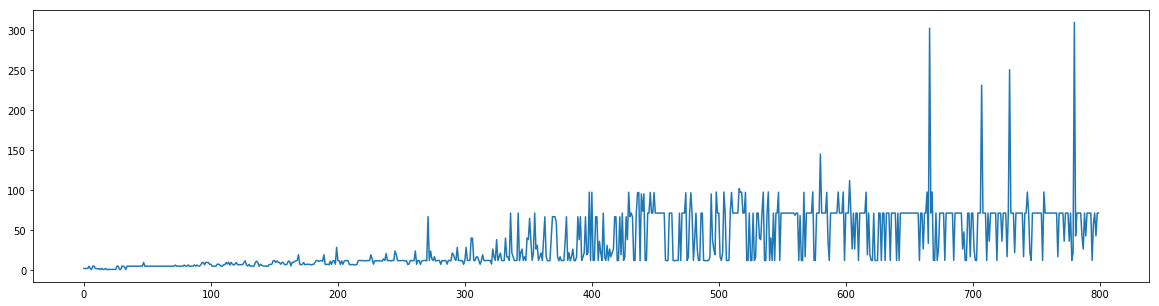

In [8]:
# plot reward against training episodes
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(reward_per_epoch)), reward_per_epoch)
plt.show()

In [9]:
from moviepy.editor import *
clip = VideoFileClip("movie/DQN-54000.webm")
display(clip.ipython_display(fps=60, autoplay=1, loop=1))

100%|██████████| 791/791 [00:00<00:00, 1004.58it/s]


### Report

由於上次作業的教訓這次使用了比較小的learning rate來確保不會overshot，結果表現十分好，最高reward達到310，存活時間為2470秒，而平均reward也比上次增加至少50以上。我想會提升這麼多是因為增加了seperate target network 和replay buffer這兩個方法才讓表現如此不錯。